In [1]:
import wandb
import datetime
import argparse
import numpy as np
from train_and_test import train_and_test
from helpers import get_NWP_data, get_rain_gauge_or_radar_data
from helpers import sw_func, find_experiment_directory, make_name_string
from helpers import use_old_forecasts_as_observations
from evaluator import only_MSE_and_GSS,get_best_GSS
import sys
from tensorflow import device
from models.model import model


import pandas as pd
from missingno import matrix
import matplotlib.pyplot as plt

# Overview of notebook
- Common parameters
- Evaluation methods
    - 
- Best simulation model
    - Parameters
    - Performance in Cross-validation
    - Performance on testing data (2020)

- Best forecast model
 

# Common parameters

In [2]:

# Fixed paramters
project = "Thesis Experiment 2 and 3 evaluation"
d_start = datetime.datetime(2015, 1, 1)
d_end = datetime.datetime(2020, 12, 31, 23, 59, 59)
# d_end = datetime.datetime(2019, 12, 31, 23, 59, 59)
max_lag = 24
pred_dist = 60
t_roll = 24
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "RVK-BOD": [0, 15,  30,  45,  60,  75,  90,  105, 120, 135, 150],
}
thresholds = np.array(list(threshold_dict.values()))
temperature_name = "1475_T"

experiment_dir = find_experiment_directory()
data_directory = f"{experiment_dir}/Data/"
save_dir = f"{experiment_dir}/predictions/"

early_stopper_params = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 20,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
    }

evaluation_config = {
    'eval_forecast_start': 24,
    'eval_forecast_end':30,
}

# Data

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("-r","--regularization",type=float,default=0.1,metavar="regularization",)
parser.add_argument("-u","--units",type=int,default=0,metavar="units",)
parser.add_argument("-f","--filters",type=int,default=0,metavar="filters",)
parser.add_argument("-l","--lr",type=float,default=0.1,metavar="lr",)
parser.add_argument("-w","--weights",type=str,default='a',metavar="lr",)
parser.add_argument("-b","--batch_size",type=int,default=256,metavar="batch_size",)
parser.add_argument("-d","--data_source",type=str,default='gauge',metavar="data_source",)
parser.add_argument("-o","--obs",type=int,default='3',metavar="obs",)
# Best gauge
args_list = [
    '-r','0',
    '-u','0',
    '-f','5',
    '-l','0.1',
    '-w','a',
    '-b','254',
    '-d','gauge',
    '-o','48'
]

# Best radar
# args_list = [
#     '-r','0.1',
#     '-u','0',
#     '-f','5',
#     '-l','0.1',
#     '-w','a',
#     '-b','254',
#     '-d','radar',
#     '-o','24'
# ]
# # Best NWP
# args_list = [
#     '-r','0.1',
#     '-u','0',
#     '-f','1',
#     '-l','0.1',
#     '-w','a',
#     '-b','254',
#     '-d','NWP',
#     '-o','48'
# ]
args = parser.parse_args(args_list)

# Simulation

In [5]:
config_model = {
    'regularization':args.regularization,
    'units':args.units,
    'filters':args.filters,
    
    'lr': args.lr,
    'batch_size': args.batch_size,
    'data_source': args.data_source,
    'obs': args.obs,
}

In [6]:

# Get data
if args.data_source == "NWP":
    X1, X2, X3, Y = get_NWP_data(threshold_dict,temperature_name,config_model['obs'],pred_dist,d_start,d_end)
    data_dates = get_NWP_data(threshold_dict,temperature_name,config_model['obs'],pred_dist,d_start,d_end,return_just_dates=True)
    n,f,*_ = X1.shape
    X1 = X1.reshape((n,f,-1))
    X2 = X2.reshape((n,f,-1))
    X3 = X3.reshape((n,f,-1))
    # Transform such that the shape is (n*f,obs,-1)
    # and for 'observations' of rainfall, we instead use old forecasts
    X_before_obs = np.concatenate([X1,X2,X3],axis=-1)
    n,f,p = X_before_obs.shape
    X_after_obs = use_old_forecasts_as_observations(X_before_obs, data_dates, config_model['obs']-1)
    X = np.lib.stride_tricks.sliding_window_view(X_after_obs, (1,config_model['obs'],p)).reshape(-1,config_model['obs'],p)
    
elif args.data_source == "radar":
    X1,_,X2,X3,Y = get_rain_gauge_or_radar_data(threshold_dict,temperature_name,config_model['obs'],d_start,d_end)
    data_dates = get_rain_gauge_or_radar_data(threshold_dict,temperature_name,config_model['obs'],d_start,d_end,return_just_dates = True)
    X = np.concatenate([X1, X2, X3],axis=-1)
elif args.data_source == "gauge":
    _,X1,X2,X3,Y = get_rain_gauge_or_radar_data(threshold_dict,temperature_name,config_model['obs'],d_start,d_end)
    data_dates = get_rain_gauge_or_radar_data(threshold_dict,temperature_name,config_model['obs'],d_start,d_end,return_just_dates = True)
    X = np.concatenate([X1, X2, X3],axis=-1)
    
X = X.astype('float32')
Y = Y.reshape(-1,2).astype('float32')

# Sample weights function
if args.weights == "a":
    relative_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
elif args.weights == "b":
    relative_weights = [0.5, 1, 1.5, 2,4,6,8,10,12,15,20]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)

run = wandb.init(config=config_model, project=project)
model_constructor = lambda : model(config_model)

    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sverrirhd (use `wandb login --relogin` to force relogin)


In [7]:
model_constructor = lambda : model(config_model)

In [8]:
if args.data_source == 'NWP':
    df_y_tmp = pd.DataFrame(Y.reshape(-1,60*2),index = data_dates)
    pre_2020_indexes = np.argwhere(df_y_tmp.index < datetime.datetime(2020,1,1,0,0,0)).ravel()
    post_2020_indexes = np.argwhere(df_y_tmp.index > datetime.datetime(2020,1,1,0,0,0)).ravel()
    
    pre_2020_bool_matrix = np.full((len(data_dates),60),False)
    post_2020_bool_matrix = np.full((len(data_dates),60),False)
    
    pre_2020_bool_matrix[pre_2020_indexes] = True
    post_2020_bool_matrix[post_2020_indexes] = True
    
    pre_2020_bool_matrix = pre_2020_bool_matrix.ravel()
    post_2020_bool_matrix = post_2020_bool_matrix.ravel()
else:
    df_y_tmp = pd.DataFrame(Y,index = data_dates[:,-1])
    pre_2020_indexes = np.argwhere(df_y_tmp.index < datetime.datetime(2020,1,1,0,0,0)).ravel()
    post_2020_indexes = np.argwhere(df_y_tmp.index > datetime.datetime(2020,1,1,0,0,0)).ravel()


In [9]:
if args.data_source == 'NWP':
    X_train = X[pre_2020_bool_matrix]
    X_test = X[post_2020_bool_matrix]

    Y_train = Y[pre_2020_bool_matrix]
    Y_test = Y[post_2020_bool_matrix]
else:
    X_train = X[pre_2020_indexes]
    X_test = X[post_2020_indexes]

    Y_train = Y[pre_2020_indexes]
    Y_test = Y[post_2020_indexes]

In [10]:
model_constructor=model_constructor
input_data=X_train
output_data=Y_train
weight_func=sample_weights_function
config=config_model

In [11]:
from sklearn.model_selection import TimeSeriesSplit
# Logging dicts
models, input_output_pred = {}, {}

# cross_validation
cross_val = TimeSeriesSplit(5)
index = np.arange(0,len(output_data))
splits = cross_val.split(index)

In [12]:
from sklearn.preprocessing import StandardScaler
standardizer=StandardScaler

In [13]:
fold_data = {}
fold_data['fold'] = 0

# Apply indexes
input_train = input_data
fold_data['Y_train'] = Y_train
fold_data['Y_val'] = Y_test

# Unfold data for standardiztaion
n,f,p = input_data.shape
input_train = X_train.reshape((-1,p))
input_val = X_test.reshape((-1,p))

# Apply standardization and re-fold for training
std = standardizer()
fold_data['X_train'] = std.fit_transform(input_train).reshape((-1,f,p))
fold_data['X_val'] = std.transform(input_val).reshape((-1,f,p))


In [14]:
# Train model and predict
with device('cpu:0'):
    model_instance = model_constructor()
    model_instance.fit(fold_data,
                weight_func=weight_func)


Epoch 1/100
154/154 [==============================] - 4s 10ms/step - loss: 4899.6367 - val_loss: 2331.6687
Epoch 2/100
154/154 [==============================] - 1s 6ms/step - loss: 2800.9609 - val_loss: 2479.1636
Epoch 3/100
154/154 [==============================] - 1s 6ms/step - loss: 2847.8416 - val_loss: 2457.4736
Epoch 4/100
154/154 [==============================] - 1s 6ms/step - loss: 2834.4995 - val_loss: 2540.8882
Epoch 5/100
154/154 [==============================] - 1s 6ms/step - loss: 2852.8784 - val_loss: 2385.3223
Epoch 6/100
154/154 [==============================] - 1s 6ms/step - loss: 2826.5200 - val_loss: 2457.1394
Epoch 7/100
154/154 [==============================] - 1s 5ms/step - loss: 2715.8774 - val_loss: 2282.6060
Epoch 8/100
154/154 [==============================] - 1s 5ms/step - loss: 2694.6770 - val_loss: 2279.8303
Epoch 9/100
154/154 [==============================] - 1s 5ms/step - loss: 2704.8633 - val_loss: 2286.7100
Epoch 10/100
154/154 [==============

In [ ]:
# model_instance.model.predict(fold_data['X_train'])

In [16]:
with device('cpu:0'):
    fold_data['Y_train_pred'] = model_instance.predict(fold_data['X_train'])
    fold_data['Y_val_pred'] = model_instance.predict(fold_data['X_val'])
    input_output_pred[0] = fold_data


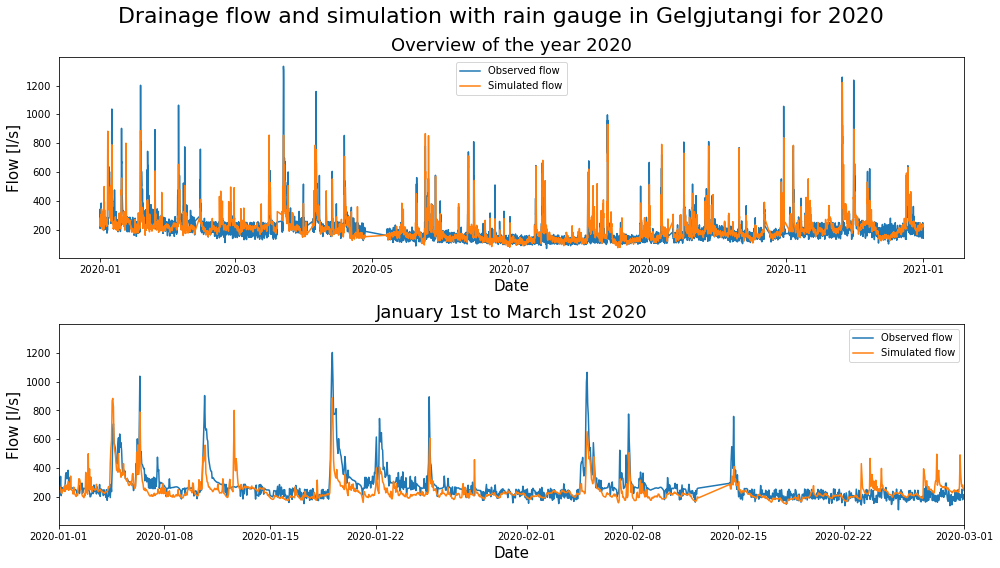

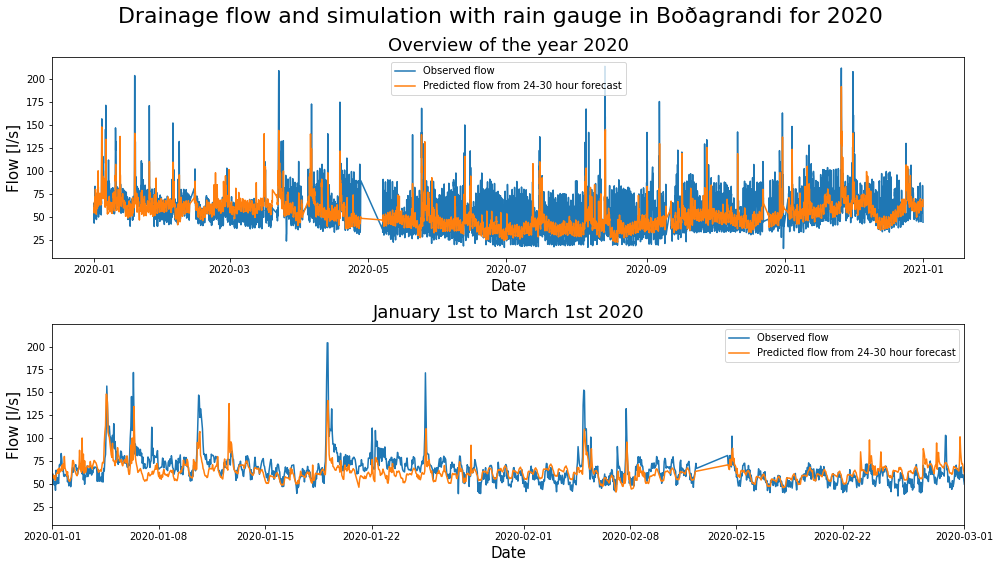

In [33]:

fig_size = (14,8)
title_size = 22
subtitle_size = 18
label_size = 15
x_label = 'Date'
y_label = 'Flow [l/s]'
zoom_in_dates = datetime.datetime(2020,1,1),datetime.datetime(2020,3,1)
title_2020 = 'Overview of the year 2020'
title_zoom = 'January 1st to March 1st 2020'

save_dir = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/saved images/Experiment eval/'
if args.data_source == 'NWP':
    pred_dates_24_30 = [[i + datetime.timedelta(hours = offset) for offset in range(24,30)] for i in  data_dates]
    pred_dates_24_30_train = pd.DatetimeIndex(np.array(pred_dates_24_30)[pre_2020_indexes].ravel())
    pred_dates_24_30_test= pd.DatetimeIndex(np.array(pred_dates_24_30)[post_2020_indexes].ravel())

    y_pred_0 = fold_data['Y_val_pred'].reshape(-1,60,2)[:,24:30,0].ravel()
    y_true_0 = fold_data['Y_val'].reshape(-1,60,2)[:,24:30,0].ravel()
    df_y_pred_0 = pd.DataFrame(y_pred_0,index = pred_dates_24_30_test)
    df_y_true_0 = pd.DataFrame(y_true_0,index = pred_dates_24_30_test)
    
    y_pred_1 = fold_data['Y_val_pred'].reshape(-1,60,2)[:,24:30,1].ravel()
    y_true_1 = fold_data['Y_val'].reshape(-1,60,2)[:,24:30,1].ravel()
    df_y_pred_1 = pd.DataFrame(y_pred_1,index = pred_dates_24_30_test)
    df_y_true_1 = pd.DataFrame(y_true_1,index = pred_dates_24_30_test)
    
    title_GEL = 'Drainage flow and 24-30 hour forecast in Gelgjutangi for 2020'
    title_BOD = 'Drainage flow and 24-30 hour forecast in Boðagrandi for 2020'
    pred_label = 'Predicted flow from 24-30 hour forecast'
    save_name = 'NWP_pred_'
    
else:
    pred_dates_train = pd.DatetimeIndex(np.array(data_dates[:,-1])[pre_2020_indexes].ravel())
    pred_dates_test= pd.DatetimeIndex(np.array(data_dates[:,-1])[post_2020_indexes].ravel())
    y_pred_0 = fold_data['Y_val_pred'][:,0]
    y_true_0 = fold_data['Y_val'][:,0]
    df_y_pred_0 = pd.DataFrame(y_pred_0,index = pred_dates_test)
    df_y_true_0 = pd.DataFrame(y_true_0,index = pred_dates_test)
    
    y_pred_1 = fold_data['Y_val_pred'][:,1]
    y_true_1 = fold_data['Y_val'][:,1]
    df_y_pred_1 = pd.DataFrame(y_pred_1,index = pred_dates_test)
    df_y_true_1 = pd.DataFrame(y_true_1,index = pred_dates_test)
    
    if args.data_source == 'gauge':
        title_GEL = 'Drainage flow and simulation with rain gauge in Gelgjutangi for 2020'
        title_BOD = 'Drainage flow and simulation with rain gauge in Boðagrandi for 2020'
        save_name = 'Gauge_pred_'
    elif args.data_source == 'radar':
        title_GEL = 'Drainage flow and simulation with radar data in Gelgjutangi for 2020'
        title_BOD = 'Drainage flow and simulation with radar data in Boðagrandi for 2020'
        save_name = 'Radar_pred_'

    pred_label = 'Simulated flow'
    

f,ax = plt.subplots(2,1,figsize=fig_size)
f.suptitle(title_GEL,fontsize=title_size)
ax[0].plot(df_y_true_0,label='Observed flow')
ax[0].plot(df_y_pred_0,label=pred_label)

ax[0].legend()
ax[0].set_xlabel(x_label,fontsize=label_size)
ax[0].set_ylabel(y_label,fontsize=label_size)
ax[0].set_title(title_2020,fontsize = subtitle_size)

ax[1].plot(df_y_true_0,label='Observed flow')
ax[1].plot(df_y_pred_0,label=pred_label)

ax[1].legend()
ax[1].set_xlabel(x_label,fontsize=label_size)
ax[1].set_ylabel(y_label,fontsize=label_size)
ax[1].set_title(title_zoom,fontsize = subtitle_size)

ax[1].set_xlim(*zoom_in_dates)
plt.tight_layout()
plt.savefig(save_dir + save_name + 'GEL')
plt.show()

    
    

f,ax = plt.subplots(2,1,figsize=fig_size)
f.suptitle(title_BOD,fontsize=title_size)
# f.suptitle('Drainage flow observations in Boðagrandi for 2020\ncompared with simulation with rain gauge data',fontsize=title_size)
ax[0].plot(df_y_true_1,label='Observed flow')
ax[0].plot(df_y_pred_1,label='Predicted flow from 24-30 hour forecast')

ax[0].legend()
ax[0].set_xlabel(x_label,fontsize=label_size)
ax[0].set_ylabel(y_label,fontsize=label_size)
ax[0].set_title(title_2020,fontsize = subtitle_size)

ax[1].plot(df_y_true_1,label='Observed flow')
ax[1].plot(df_y_pred_1,label='Predicted flow from 24-30 hour forecast')

ax[1].legend()
ax[1].set_xlabel(x_label,fontsize=label_size)
ax[1].set_ylabel(y_label,fontsize=label_size)
ax[1].set_title(title_zoom,fontsize = subtitle_size)
ax[1].set_xlim(*zoom_in_dates)
plt.tight_layout()
plt.savefig(save_dir + save_name + 'BOD')
plt.show()

In [39]:
import hydroeval
def eval_dict_NWP(y_true_all,y_pred_all,start,end,sensor):
    y_pred = y_pred_all.reshape(-1,60,2)[:,start:end,sensor].ravel()
    y_true = y_true_all.reshape(-1,60,2)[:,start:end,sensor].ravel()
    
    nse = hydroeval.nse(y_pred,y_true)
    rmse = hydroeval.rmse(y_pred,y_true)
    corr = np.corrcoef(y_pred,y_true)[0,1]
    resids = y_pred - y_true
    mse = np.mean(resids**2)

    
    stats_dict = {
        'MSE':mse,
        'RMSE':rmse,
        'Correlation':corr,
        'NSE':nse,
    }
    
    return stats_dict

def eval_dict(y_true_all,y_pred_all,start,end,sensor):
    y_pred = y_pred_all[:,sensor].ravel()
    y_true = y_true_all[:,sensor].ravel()
    
    nse = hydroeval.nse(y_pred,y_true)
    rmse = hydroeval.rmse(y_pred,y_true)
    corr = np.corrcoef(y_pred,y_true)[0,1]
    resids = y_pred - y_true
    mse = np.mean(resids**2)

    
    stats_dict = {
        'MSE':mse,
        'RMSE':rmse,
        'Correlation':corr,
        'NSE':nse,
    }
    
    return stats_dict

if args.data_source == 'NWP':
    eval_val_0 = eval_dict_NWP(fold_data['Y_val'],fold_data['Y_val_pred'],24,30,0)
    eval_val_1 = eval_dict_NWP(fold_data['Y_val'],fold_data['Y_val_pred'],24,30,1)

    eval_train_0 = eval_dict_NWP(fold_data['Y_train'],fold_data['Y_train_pred'],24,30,0)
    eval_train_1 = eval_dict_NWP(fold_data['Y_train'],fold_data['Y_train_pred'],24,30,1)

else:
    eval_val_0 = eval_dict(fold_data['Y_val'],fold_data['Y_val_pred'],24,30,0)
    eval_val_1 = eval_dict(fold_data['Y_val'],fold_data['Y_val_pred'],24,30,1)

    eval_train_0 = eval_dict(fold_data['Y_train'],fold_data['Y_train_pred'],24,30,0)
    eval_train_1 = eval_dict(fold_data['Y_train'],fold_data['Y_train_pred'],24,30,1)

    
    
GSS_train_0,GSS_test_0 = get_best_GSS(fold_data,500,0,evaluation_config)
GSS_train_1,GSS_test_1 = get_best_GSS(fold_data,90,1,evaluation_config)

eval_val_0['GSS'] = GSS_test_0
eval_val_1['GSS'] = GSS_test_1
eval_train_0['GSS'] = GSS_train_0
eval_train_1['GSS'] = GSS_train_1

cols = pd.MultiIndex.from_tuples([('Test','GEL'),('Test','BOD'),('Train','GEL'),('Train','BOD')])

df_eval = pd.DataFrame([eval_val_0,eval_val_1,eval_train_0,eval_train_1],index = cols).T
df_eval = df_eval.round(3)
df_eval

Test              Train         
                  GEL      BOD       GEL      BOD
MSE          4131.468  321.550  5042.482  256.401
RMSE           64.276   17.932    71.010   16.013
Correlation     0.783    0.588     0.793    0.701
NSE             0.611    0.316     0.629    0.489
GSS             0.351    0.222     0.444    0.245

In [41]:
print(df_eval.to_latex(label='tab:gauge_drainage_eval',multicolumn_format='c',column_format='lcccc'))

\begin{table}
\centering
\label{tab:gauge_drainage_eval}
\begin{tabular}{lcccc}
\toprule
{} & \multicolumn{2}{c}{Test} & \multicolumn{2}{c}{Train} \\
{} &       GEL &      BOD &       GEL &      BOD \\
\midrule
MSE         &  4131.468 &  321.550 &  5042.482 &  256.401 \\
RMSE        &    64.276 &   17.932 &    71.010 &   16.013 \\
Correlation &     0.783 &    0.588 &     0.793 &    0.701 \\
NSE         &     0.611 &    0.316 &     0.629 &    0.489 \\
GSS         &     0.351 &    0.222 &     0.444 &    0.245 \\
\bottomrule
\end{tabular}
\end{table}



In [44]:
# pd.DataFrame([eval_val_0,eval_val_1,eval_train_0,eval_train_1]).T

<AxesSubplot:>

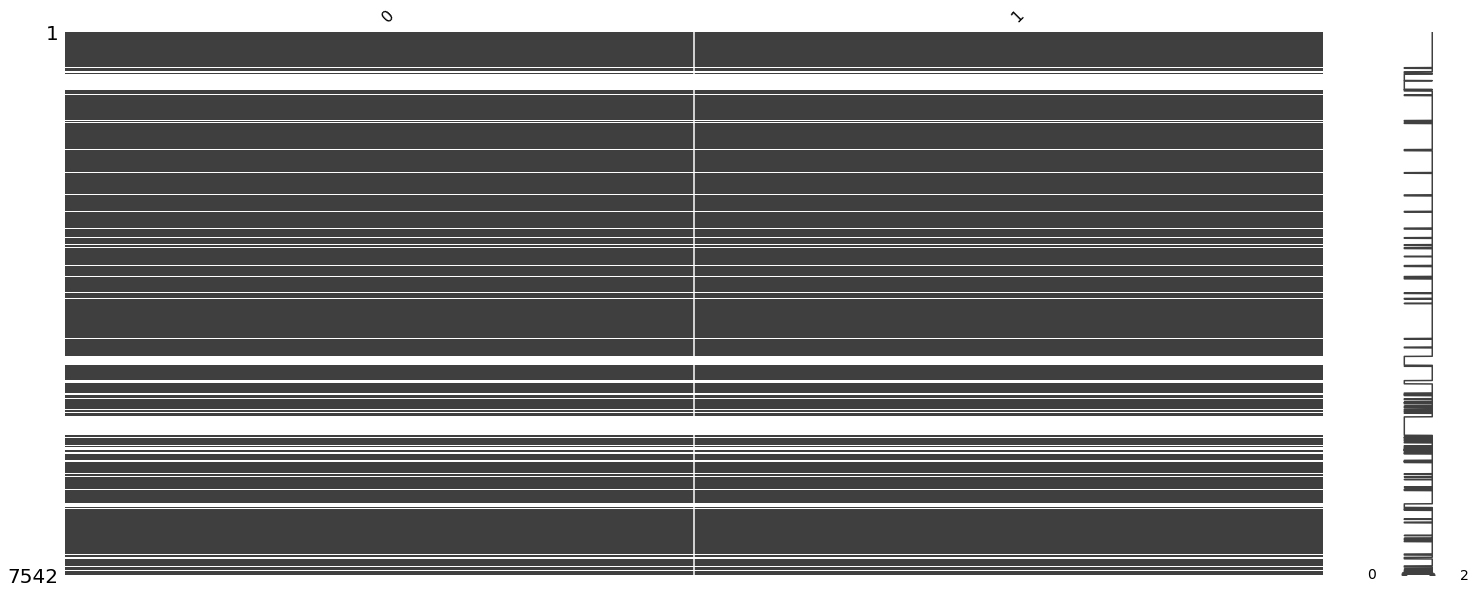

In [ ]:
matrix(df_y_pred_1.resample('6h').mean())

In [42]:
minimum_eval_dict

{'folds': {},
 'summary': {'total_mean_squared_error': 3238.0479,
  'total_mean_absolute_error': 28.107822,
  'total_weighted_mean_squared_error': 3238.0477984047116,
  'total_weighted_mean_absolute_error': 28.10782319993111,
  'GSS_val_0': 0.24371134138718864,
  'GSS_val_1': 0.15711925538405347,
  'GSS_val_average': 0.20041529838562105}}

In [25]:
minimum_eval_dict = only_MSE_and_GSS(input_output_pred,sample_weights_function,evaluation_config)
wandb.log(minimum_eval_dict['summary'])
run.finish()

c:\Users\sverrirhd\Google Drive\Skóli\DTU\Thesis\Programming\Experiments\evaluator.py:14: RuntimeWarning: overflow encountered in long_scalars
  TP_rand = (TP + FN)*(TP + FP)/(len(y_true_cls))


GSS_val_0,▁
GSS_val_1,▁
GSS_val_average,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▄▄▃▃▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████████▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_mean_absolute_error,▁
total_mean_squared_error,▁
total_weighted_mean_absolute_error,▁
total_weighted_mean_squared_error,▁
val_loss,▂▃▄█▁▂▅▂▁▂▂▄▂▂▂▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Forecast

In [ ]:

experiment_dir = find_experiment_directory()
data_directory = f"{experiment_dir}/Data/"
save_dir = f"{experiment_dir}/predictions/"


parser = argparse.ArgumentParser()


# Data source argument
if args.datasource == "NWP":
    X1, X2, X3, Y12 = get_NWP_data(
        threshold_dict,
        temperature_name,
        max_lag,
        pred_dist,
        d_start,d_end)
    rain_shape = (-1, pred_dist, 100)
    temp_shape = (-1, pred_dist, 1)
    patt_shape = (-1, pred_dist, 24)
elif args.datasource == "radar":
    pred_dist_tmp = 1
    X1,_,X2,X3,Y12 = get_rain_gauge_or_radar_data(
        threshold_dict,
        temperature_name,
        n_obs,
        d_start,d_end)
    rain_shape = (-1, n_obs* 20*20)
    temp_shape = (-1, n_obs* 1)
    patt_shape = (-1, n_obs* 24)
    
elif args.datasource == "gauge":
    pred_dist_tmp = 1
    _,X1,X2,X3,Y12 = get_rain_gauge_or_radar_data(
        threshold_dict,
        temperature_name,
        n_obs,
        d_start,d_end)
    rain_shape = (-1, n_obs, 1)
    temp_shape = (-1, n_obs, 1)
    patt_shape = (-1, n_obs, 24)

# Rainfall argument
if args.include == "r":
    input_data = [X1.reshape(rain_shape)]
elif args.include == "rt":
    input_data = [
        X1.reshape(rain_shape),
        X2.reshape(temp_shape)
        ]
elif args.include == "rth":
    input_data = [
        X1.reshape(rain_shape),
        X2.reshape(temp_shape),
        X3.reshape(patt_shape),
    ]
else:
    parser.print_help()
    sys.exit(1)


AttributeError: 'Namespace' object has no attribute 'datasource'